### データ詳細

データはここから選択
http://archive.ics.uci.edu/ml/index.php

以下をクリックするととExcelデータがダウンロードされる。これを元にデータ分析
http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx

おそらくとある企業のオンラインでの購買データと思われる。

In [1]:
# モジュールの読み込み
import numpy as np
import pandas as pd
from pandas import DataFrame

# 可視化モジュール
import matplotlib.pyplot as plt
%matplotlib inline

# 小数第３まで表示
%precision 3

'%.3f'

In [2]:
# Excelシート読み込み
sheet='Online Retail.xlsx'
file = pd.ExcelFile(sheet)
original_online_retail_data = file.parse('Online Retail')

In [3]:
original_online_retail_data.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [4]:
original_online_retail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


### 前処理すべきこと
①InvoiceNoには数字の前にAやCなどの異常値があるので取り除く

②CustomerIDにnanが含まれる：1600あたり(1442~1973)

In [5]:
# CustomerIDの処理
online_retail_data2 = DataFrame(original_online_retail_data.CustomerID.dropna())

In [6]:
#InvoiceNoの処理
original_online_retail_data.loc[:,"First_InvoiceNo"]  = original_online_retail_data["InvoiceNo"].map(lambda x: str(x)[0])
online_retail_data1 = original_online_retail_data[original_online_retail_data.First_InvoiceNo == '5'].drop(["First_InvoiceNo"],axis=1).drop(["CustomerID"],axis=1)

In [7]:
# mergeで前処理完了させる
online_retail_data = pd.concat([online_retail_data1,online_retail_data2], axis=1, join='inner').reset_index(drop=True)

In [8]:
online_retail_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,CustomerID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,United Kingdom,17850.0


### データの読み取り

データは購買データ。約40万件

特筆すべき項目：

①InvoiceNo：買い物カゴのバスケットの番号のようなもの。1回に２個以上InvoiceNoを持つCustomerもいる。25900種類

②StockCodeとDescription：商品の種類を表す。StockCodeが商品番号でDescriptionが具体的な商品の種類

　ただしStockCodeは4070種類に対して、Descriptionは4224種類と若干異なる。

③InvoiceDate：2010-12-01 08:26:00から2011-12-09 12:50:00まで約１年分

④Country：38か国。

⑤CustomerID：購買者。4373人

### データ分析

### ①それぞれの国の購買合計金額を求め、上位5つの国を月別で時系列グラフにする

In [9]:
online_retail_data["TotalPrice"]=online_retail_data["UnitPrice"]*online_retail_data["Quantity"]
online_retail_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,CustomerID,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,17850.0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom,17850.0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,United Kingdom,17850.0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,United Kingdom,17850.0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,United Kingdom,17850.0,20.34


array([<matplotlib.axes._subplots.AxesSubplot object at 0x12110cda0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x124974048>], dtype=object)

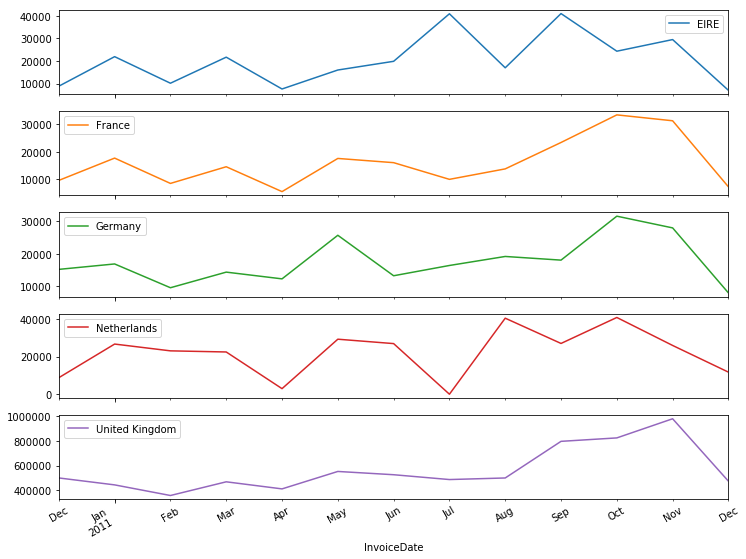

In [10]:
country_sales_data = online_retail_data.groupby(["Country","InvoiceDate"], as_index=False)["TotalPrice"].sum()
total_country_sales_data=country_sales_data.groupby("Country", as_index=False)["TotalPrice"].sum().sort_values(by=["TotalPrice"],ascending=False).reset_index(drop=True)
top_five_countries=total_country_sales_data[0:5].Country.values
top_country_sales_data = country_sales_data[country_sales_data["Country"].isin(top_five_countries)]
pivot_data=top_country_sales_data.pivot(index="InvoiceDate",columns="Country",values="TotalPrice")
#subplots=Trueとすると国別、 Falseとすると全てのグラフがまとまって１つになって表示される
pivot_data.resample('M').sum().plot(subplots=True ,figsize=(12,10))

In [11]:
total_country_sales_data.head()

,Country,TotalPrice
0,United Kingdom,7308391.554
1,Netherlands,285446.340
2,EIRE,265545.900
3,Germany,228867.140
4,France,209024.050


### データからわかること
#### 売り上げtop5の国はUnited Kingdom, Netherlands, EIRE, Germany, Franceで圧倒的にUnited Kingdomでの売り上げが大きい。Netherlands 以下はほぼ同額

#### データからわかるのは国ごとで月間売り上げがかなり違うというとこ→国別の動向を分析し原因を追求するには国別の商品の解析が必要

#### 全体としてはUKでの8~9月、10~11月で売り上げが大きく伸びたということがわかる。(最後は12/9終わりなので12月売上が小さいこと関しては検討しなくて良いと思われる)

### ②月と国を指定して、その国でのトップセールスを出した商品を調べ、売上を月別で時系列グラフにする

In [12]:
description_invoicedate_country_totalprice_data=online_retail_data[online_retail_data["Country"].isin(top_five_countries)][["Description","InvoiceDate","Country","TotalPrice"]]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11e74e4a8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x12457b278>], dtype=object)

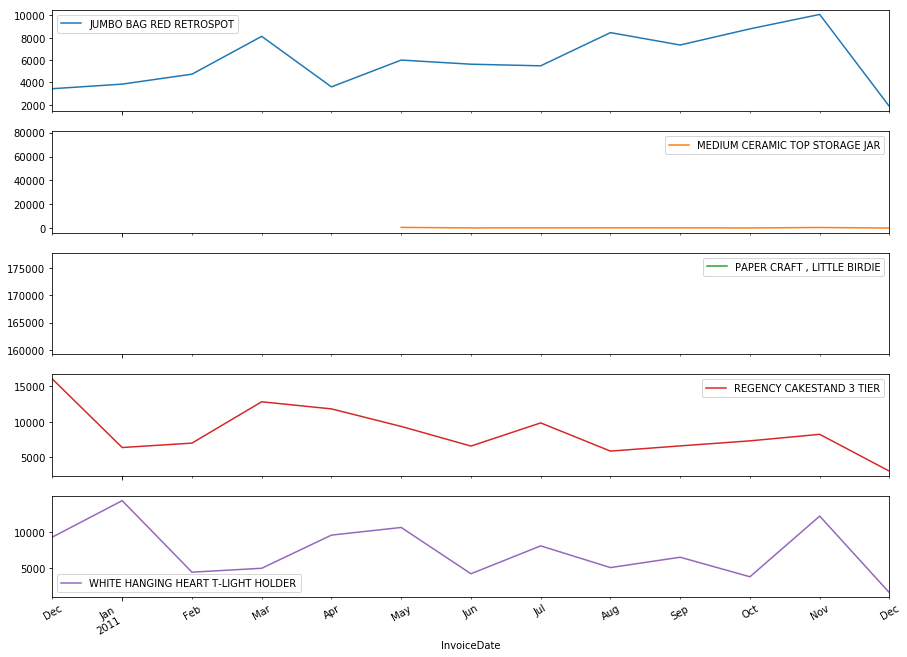

In [13]:
# countryの指定。 'United Kingdom', 'Netherlands', 'EIRE', 'Germany','France'から指定 
country=top_five_countries[0]

country_data=description_invoicedate_country_totalprice_data[description_invoicedate_country_totalprice_data["Country"]==country]
# top5としているが[0:5]をいじれば売上ランキングtop5以外のDescriptionも見れる
top_five_sales_description = country_data.groupby("Description",as_index=False)["TotalPrice"].sum()\
                .sort_values(by=["TotalPrice"],ascending=False).reset_index(drop=True)[0:5].Description.values
top_five_sales_description_data=country_data[country_data["Description"].isin(top_five_sales_description)].groupby(["Description","InvoiceDate"],as_index=False)["TotalPrice"].sum()
pivot_description_data = top_five_sales_description_data.pivot(index="InvoiceDate",columns="Description",values="TotalPrice")

#subplots=Trueとすることで個別にグラフを表示できる
pivot_description_data.resample('M').sum().plot(subplots=True, figsize=(15,12))

### データからわかること
#### そもそも欠損データなどが多くて推移を綺麗にだすことはできなかったが、全体的な流れからも売上の変化が読み取れる

#### 例えばUKで売上No.1のPAPER CRAFT , LITTLE BIRDIEは最終日の12/9のみの売上データだが、これだけでUK全商品の中で最も売上が大きいデータとなっている(UK全体では2.3%程度の売上を占める)。つまり１点のみのデータで推移が確認できない

#### ということで国別の商品の解析はこのデータだけでは困難であった

In [14]:
# 気になるDescriptionを含むDataFrameはこれで確認ができる
top_five_sales_description_data.head()

,Description,InvoiceDate,TotalPrice
0,JUMBO BAG RED RETROSPOT,2010-12-01 09:57:00,165.00
1,JUMBO BAG RED RETROSPOT,2010-12-01 10:19:00,165.00
2,JUMBO BAG RED RETROSPOT,2010-12-01 11:45:00,3.90
3,JUMBO BAG RED RETROSPOT,2010-12-01 12:23:00,1.95
4,JUMBO BAG RED RETROSPOT,2010-12-01 12:49:00,1.95


In [15]:
# monthの指定で細かく見ることも可能
month = 11 

top_five_sales_description_data["Month"]=list(map(lambda x: x.month, top_five_sales_description_data["InvoiceDate"]))
top_five_sales_description_data[top_five_sales_description_data["Month"]==month].head()

,Description,InvoiceDate,TotalPrice,Month
1208,JUMBO BAG RED RETROSPOT,2011-11-01 09:01:00,62.40,11
1209,JUMBO BAG RED RETROSPOT,2011-11-01 09:56:00,20.80,11
1210,JUMBO BAG RED RETROSPOT,2011-11-01 10:21:00,41.60,11
1211,JUMBO BAG RED RETROSPOT,2011-11-01 12:45:00,20.80,11
1212,JUMBO BAG RED RETROSPOT,2011-11-01 13:44:00,8.32,11


### ③それぞれの国における商品の売り上げTOP5の商品を調べる

In [16]:
country_description_totalprice_rough_data=online_retail_data.groupby(["Country","Description"],as_index=False)["TotalPrice"].sum()
country_description_totalprice_data=country_description_totalprice_rough_data[country_description_totalprice_rough_data.Country.isin(top_five_countries)].sort_values(by=["TotalPrice"],ascending=False).reset_index(drop=True)
country_description_totalprice_data.head()

,Country,Description,TotalPrice
0,United Kingdom,"PAPER CRAFT , LITTLE BIRDIE",168469.60
1,United Kingdom,REGENCY CAKESTAND 3 TIER,110990.20
2,United Kingdom,WHITE HANGING HEART T-LIGHT HOLDER,94858.60
3,United Kingdom,MEDIUM CERAMIC TOP STORAGE JAR,80291.44
4,United Kingdom,JUMBO BAG RED RETROSPOT,77371.57


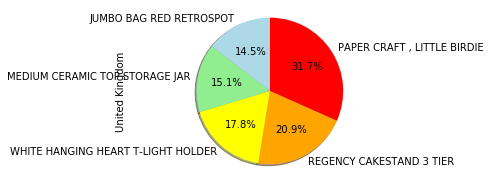

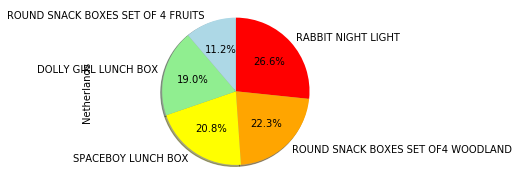

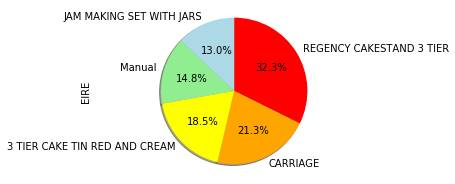

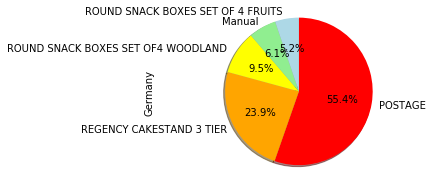

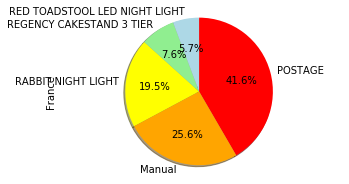

In [17]:
for country in top_five_countries:
    plt.figure(figsize=(5,3),facecolor="white")
    labels=country_description_totalprice_data[country_description_totalprice_data.Country==country][0:5].Description.values
    sizes=country_description_totalprice_data[country_description_totalprice_data.Country==country][0:5].TotalPrice.values
    colors =['red','orange','yellow','lightgreen','lightblue',]
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90, counterclock=False)
    plt.axis('equal') 
    plt.ylabel(country)

### データからわかること
#### UK, Netherlands, EIREはバランスの良い売上を行なっているが、GermanyとFranceは売上top5の商品のうちおよそ半分の売上をPOSTAGEで占めている

In [18]:
country="Germany"
description="POSTAGE"
numerator= country_description_totalprice_data[(country_description_totalprice_data["Country"]==country) & (country_description_totalprice_data["Description"]==description)]["TotalPrice"].sum()
denominator=country_description_totalprice_data[country_description_totalprice_data["Country"]==country]["TotalPrice"].sum()
ratio=numerator/denominator*100
print(country+"での"+description+"の金額："+str(numerator))
print(country+"での"+description+"の割合："+str(ratio)+"%")

GermanyでのPOSTAGEの金額：21001.0
GermanyでのPOSTAGEの割合：9.176066079210841%


#### 実際GermanyではPOSTAGEでの収入が10%程度, Franceでも7%ということで送料を中心とした収入モデルとなっている。ここからは勝手な推測だが、例えばGermanyでは送料の多くかかっている地域を特定してその顧客に商品を複数注文してもらえると送料をオフにすると言ったビジネスモデルが考えられる。